In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (accuracy_score
,classification_report
,confusion_matrix
,roc_auc_score
,balanced_accuracy_score
,roc_curve
,auc
,precision_score
,recall_score
,f1_score) 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

%matplotlib inline
sns.set_style("whitegrid")

## Data

**We download daily S&P 500 price data from 2010 through today using Yahoo Finance. This dataset includes open, high, low, close, adjusted prices, and volume. Data is sorted chronologically to maintain proper time-series structure.**

In [5]:
#RS
start_date = "2010-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")

data = yf.download("^GSPC", start=start_date, end="2025-12-07", auto_adjust=True) #Adjusted so stakeholder can see original results - AA
data = data.reset_index()
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values("Date").reset_index(drop=True)

# Fix MultiIndex issues
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

print("Data rows:", len(data))
data.head()

[*********************100%***********************]  1 of 1 completed

Data rows: 4007


Price,Date,Close,High,Low,Open,Volume
0,2010-01-04,1132.989990,1133.869995,1116.560059,1116.560059,3991400000
1,2010-01-05,1136.520020,1136.630005,1129.660034,1132.660034,2491020000
2,2010-01-06,1137.140015,1139.189941,1133.949951,1135.709961,4972660000
3,2010-01-07,1141.689941,1142.459961,1131.319946,1136.270020,5270680000
4,2010-01-08,1144.979980,1145.390015,1136.219971,1140.520020,4389590000


## Create Target Up/Down

**We defined the target direction as:**

- 1 = Next day's close is higher (UP)

- 0 = Next day's close is lower (DOWN)

The class distribution shows more UP days, which aligns with long-term market drift.

In [8]:
#RS
data['Direction'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
print(data['Direction'].value_counts(dropna=False))

Direction
1    2192
0    1815
Name: count, dtype: int64


## Feature Engineering

**We generate common technical indicators:**

- 1-day return + lagged returns
- Rolling volatility
- Simple moving averages
- Volume lag
- RSI
- MACD + MACD signal
  
These indicators capture momentum, trend, and volatility.

In [10]:
#RS
data['Return_1'] = data['Close'].pct_change(1)

lags = [1,2,3,5]
for l in lags:
    data[f'Return_lag_{l}'] = data['Return_1'].shift(l)

data['roll_std_5'] = data['Return_1'].rolling(5).std()
data['roll_std_10'] = data['Return_1'].rolling(10).std()

data['SMA_5'] = data['Close'].rolling(5).mean()
data['SMA_10'] = data['Close'].rolling(10).mean()
data['SMA_diff_5_10'] = data['SMA_5'] - data['SMA_10']

data['Volume_lag_1'] = data['Volume'].shift(1)

In [11]:
#AA - Extra technical Indicators that may improve model performance

#we can capture return variation over previous 20 days
# 20 days is about a month of market activity

data['rolling_std_20'] = data['Return_1'].rolling(20).std()

#inclusion of Bollinger bands to measure when a price unusally high or low 

band_window = 20
data['SMA_20'] = data['Close'].rolling(band_window).mean()

#create upper and lower boilinger bands

#upper
data['Boilinger_Upper_20'] = data['SMA_20'] + 2 * data['rolling_std_20']

#lower
data['Boilinger_Lower_20'] = data['SMA_20'] - 2 * data['rolling_std_20']

#show the changes to show the short term trend direction
data['Slope_of_SMA_20'] = data['SMA_20'].diff()

#track whether the volume is going more up or down

data['OBV'] =  (np.sign(data['Return_1']) * data['Volume']).cumsum()

#adding price changes over the last 5 days 

data['momentum_5'] = data['Close'] / data['Close'].shift(5) - 1

## Relative Strength Index (RSI) and Moving Average Convergence Divergence (MACD)

These momentum indicators help detect overbought/oversold conditions and trend strength.

In [14]:
#RS
# RSI
window = 14
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window).mean()
avg_loss = loss.rolling(window).mean()
rs = avg_gain / (avg_loss + 1e-9)
data['RSI'] = 100 - (100 / (1 + rs))

# MACD
ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema_12 - ema_26
data['MACD_signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

## Handling Missing Values

Lagged and rolling features introduced missing values in the early rows.
    
We removed these rows and fixed remaining NaNs.

In [17]:
#RS
max_lag = max(max(lags), 10)

data = data.iloc[max_lag:].reset_index(drop=True)
data = data[~data['Direction'].isna()].reset_index(drop=True)

data['RSI'] = data['RSI'].fillna(method='bfill').fillna(method='ffill')

print(data.isna().sum())

Price
Date                   0
Close                  0
High                   0
Low                    0
Open                   0
Volume                 0
Direction              0
Return_1               0
Return_lag_1           0
Return_lag_2           0
Return_lag_3           0
Return_lag_5           0
roll_std_5             0
roll_std_10            0
SMA_5                  0
SMA_10                 0
SMA_diff_5_10          0
Volume_lag_1           0
rolling_std_20        10
SMA_20                 9
Boilinger_Upper_20    10
Boilinger_Lower_20    10
Slope_of_SMA_20       10
OBV                    0
momentum_5             0
RSI                    0
MACD                   0
MACD_signal            0
dtype: int64


C:\Users\rossg\AppData\Local\Temp\ipykernel_33240\2934768788.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['RSI'] = data['RSI'].fillna(method='bfill').fillna(method='ffill')


## Prepare x and y

Raw price columns are removed to avoid leakage.

In [20]:
#RS
drop_cols = ['Date', 'Open', 'High', 'Low', 'Close']
X = data.drop(columns=drop_cols + ['Direction'], errors='ignore')
y = data['Direction']

print("Features:", X.columns.tolist())
print("Shape:", X.shape)

Features: ['Volume', 'Return_1', 'Return_lag_1', 'Return_lag_2', 'Return_lag_3', 'Return_lag_5', 'roll_std_5', 'roll_std_10', 'SMA_5', 'SMA_10', 'SMA_diff_5_10', 'Volume_lag_1', 'rolling_std_20', 'SMA_20', 'Boilinger_Upper_20', 'Boilinger_Lower_20', 'Slope_of_SMA_20', 'OBV', 'momentum_5', 'RSI', 'MACD', 'MACD_signal']
Shape: (3997, 22)


## Train/Test Split (chronological)

We use an 80/20 chronological split:
- **Training:** 2010–2022
- **Testing:** 2022–2025 This simulates real forecasting conditions.

In [23]:
#RS
split_index = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print("Train:", len(X_train), "Test:", len(X_test))

Train: 3197 Test: 800


## Evaluation helper

In [25]:
#RS

#AA - updating the model evaluation with ROC_AUC

#AA - ROC-AUC is better for imbalanced data so adding here. Accuracy can mislead by predicting majority class whereas ROC-AUC 
#looks at how well the model separates classes by checking true positive and true negative rates across thresholds.
def evaluate_model(name, model, X_test, y_test):
    preds = model.predict(X_test)

    #AA adding predicted probabilities for ROC-AUC

    probs = model.predict_proba(X_test)[:, 1] #this will give probability of UP days

    acc = accuracy_score(y_test, preds)

    #AA adding ROC-AUC
    roc_auc = roc_auc_score(y_test, probs)

    print(f"\n{name} Accuracy: {acc:.4f}")

    #AA  adding the print statement for ROC_AUC
    print(f"{name} ROC-AUC: {roc_auc:.4f}")
    
    print(classification_report(y_test, preds))

    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    plt.title(name + " Confusion Matrix")
    plt.show()

    return {'accuracy':acc, 'roc_auc': roc_auc} #AA - updated print statement for ROC_AUC 

## Logistic Regression (Tuned)

**Logistic Regression Results**

Logistic Regression achieved 43.6% accuracy.
It predicts DOWN days better than UP days but has weak performance.

This is below the baseline


Logistic Regression Accuracy: 0.4363
Logistic Regression ROC-AUC: 0.4754
              precision    recall  f1-score   support

           0       0.43      0.86      0.58       357
           1       0.46      0.09      0.15       443

    accuracy                           0.44       800
   macro avg       0.44      0.48      0.37       800
weighted avg       0.45      0.44      0.34       800



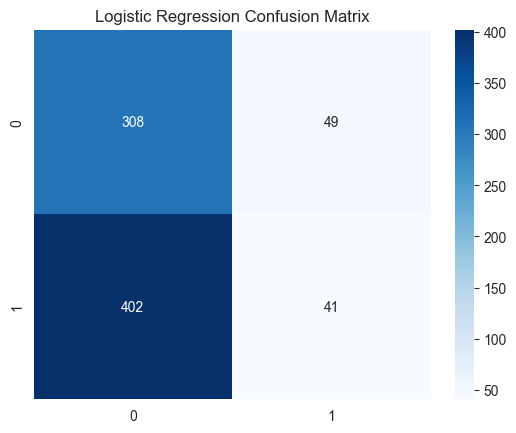

In [28]:
#RS
tscv = TimeSeriesSplit(n_splits=5)

pipe_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=2000, random_state=RANDOM_STATE,
                              class_weight = 'balanced'))]) # AA added to give more attention to DOWN days 
#to help predict them better and helps to avoid majority class domination.

param_lr = {'clf__C': [0.01, 0.1, 1, 5]}

rs_lr = RandomizedSearchCV(pipe_lr, param_lr, n_iter=4,
                           cv=tscv, scoring='roc_auc', # AA - changed from accuracy to ROC_AUC to focus on how well 
                           #the model separates UP vs. DOWN days
                           n_jobs=-1, random_state=RANDOM_STATE)

rs_lr.fit(X_train, y_train)
best_lr = rs_lr.best_estimator_

metrics_lr = evaluate_model("Logistic Regression", best_lr, X_test, y_test) #RS/AA updated naming convention

## Random Forest (Tuned)

**Random Forest Results**

Random Forest achieved 44.8% accuracy, lower than the baseline.
It performs better for DOWN days than UP days but still struggles overall.

It has the highest ROC-AUC of 0.48 but is still close to random guessing.


Random Forest (balanced) Accuracy: 0.4475
Random Forest (balanced) ROC-AUC: 0.4844
              precision    recall  f1-score   support

           0       0.43      0.74      0.54       357
           1       0.50      0.21      0.30       443

    accuracy                           0.45       800
   macro avg       0.47      0.48      0.42       800
weighted avg       0.47      0.45      0.41       800



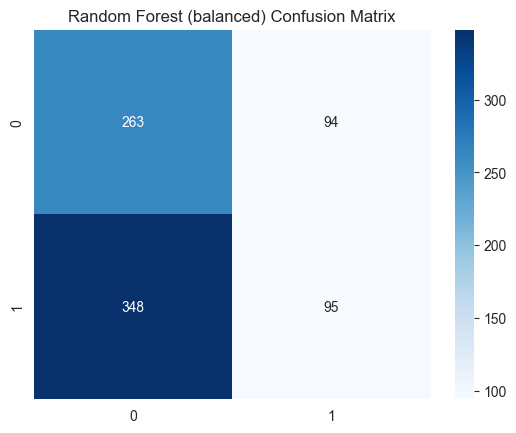

In [31]:
#RS
pipe_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE
                                  ,class_weight='balanced_subsample'))]) #AA - Added to re-weigh tree classes to help the minority class

param_rf = {
    'clf__n_estimators': [200, 300, 500],
    'clf__max_depth': [5, 10],
    'clf__min_samples_split': [2,5],
    'clf__min_samples_leaf': [1,4]}

rs_rf = RandomizedSearchCV(pipe_rf, param_rf, n_iter=6,
                           cv=tscv, scoring='roc_auc', #AA -  changed from accuracy to ROC_AUC
                           n_jobs=-1, random_state=RANDOM_STATE)


rs_rf.fit(X_train, y_train)
best_rf = rs_rf.best_estimator_

metrics_rf = evaluate_model("Random Forest (balanced)", best_rf, X_test, y_test) #RS/AA updated naming convention

## XGBoost (Tuned)

**XGBoost Results**

XGBoost achieved 46.8% accuracy.
It struggles to separate the overall classes but predicts DOWN days slighly better than UP days.

This is below baseline and has an ROC-AUC of 0.48 which shows its close to random guessing

In [34]:
#AA - need to add class balance for XGBoost

#AA compute DOWN days compared to UP
down_up_ratio = (y_train == 0).sum() / (y_train == 1).sum()

#AA - print out results
print("Class ratio (DOWN / UP):", down_up_ratio)

Class ratio (DOWN / UP): 0.8363009764503159



XGBoost Accuracy: 0.4675
XGBoost ROC-AUC: 0.4796
              precision    recall  f1-score   support

           0       0.43      0.61      0.50       357
           1       0.53      0.35      0.42       443

    accuracy                           0.47       800
   macro avg       0.48      0.48      0.46       800
weighted avg       0.49      0.47      0.46       800



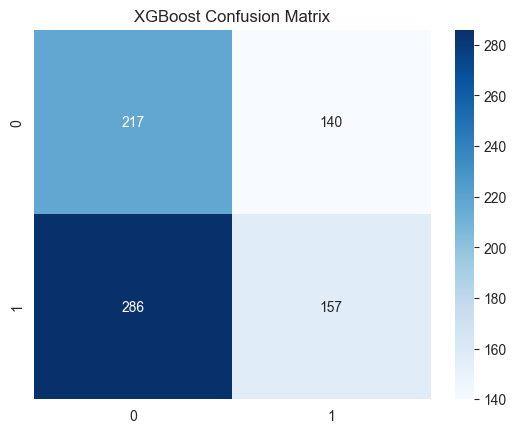

XGBoost metrics: {'accuracy': 0.4675, 'roc_auc': 0.4796270652730618}


In [35]:
#RS
pipe_xgb = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(eval_metric='logloss',
                          random_state=RANDOM_STATE,
                          n_jobs=-1
                         ,scale_pos_weight = down_up_ratio))]) # AA - giving more weight to DOWN by shrinking the weight of UP

param_xgb = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [2, 3, 5],
    'clf__learning_rate': [0.01, 0.1]}

rs_xgb = RandomizedSearchCV(pipe_xgb, param_xgb, n_iter=6,
                            cv=tscv, scoring='roc_auc', # AA - changed from accuracy to ROC_AUC
                            n_jobs=-1, random_state=RANDOM_STATE)

rs_xgb.fit(X_train, y_train)
best_xgb = rs_xgb.best_estimator_

# AA - updating with the updated model evaluation which includes accuracy, ROC_AUC, and confusion matrix
metrics_xgb = evaluate_model("XGBoost", best_xgb, X_test, y_test)
print("XGBoost metrics:", metrics_xgb)

## LightGBM (Tuned)

**LightGBM Results**

LightGBM achieved 47.3% accuracy.
compared to other models, it has a more balanced performance for UP and DOWN days, but overall its still limited.

It has a ROC-AUC score of 0.48 which is still close to but below random guessing.

[LightGBM] [Info] Number of positive: 1741, number of negative: 1456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 3197, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.544573 -> initscore=0.178767
[LightGBM] [Info] Start training from score 0.178767

LightGBM Accuracy: 0.4738
LightGBM ROC-AUC: 0.4727
              precision    recall  f1-score   support

           0       0.44      0.61      0.51       357
           1       0.54      0.36      0.43       443

    accuracy                           0.47       800
   macro avg       0.49      0.49      0.47       800
weighted avg       0.49      0.47      0.47       800



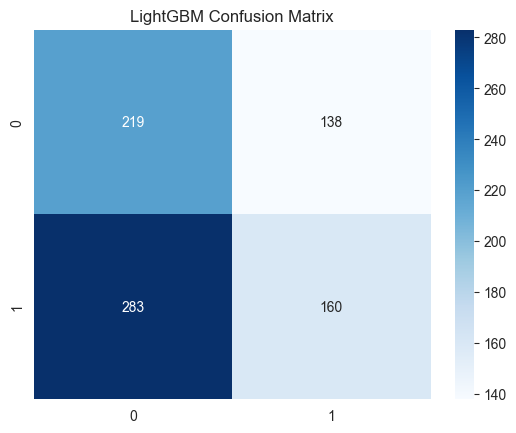

LightGBM metrics: {'accuracy': 0.47375, 'roc_auc': 0.4726811717915157}


In [38]:
# Trying the addition of LightGBM to see if we get better performance - AA

# Tuned LightGBM - AA

pipe_lgb = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', LGBMClassifier(objective='binary',
                          random_state=RANDOM_STATE,
                          n_jobs=-1))
])

pipe_lgb.set_output(transform="pandas") #added to clear feature name warning - AA

param_lgb = {
    'clf__n_estimators': [100, 200, 400],
    'clf__max_depth': [-1, 3, 5],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__num_leaves': [15, 31, 63]
}


rs_lgb = RandomizedSearchCV(pipe_lgb
                            , param_lgb
                            , n_iter=8
                            ,cv=tscv
                            , scoring='roc_auc'
                            ,n_jobs=-1, random_state=RANDOM_STATE)

rs_lgb.fit(X_train, y_train)
best_lgb = rs_lgb.best_estimator_

metrics_lgb = evaluate_model("LightGBM", best_lgb, X_test, y_test)
print("LightGBM metrics:", metrics_lgb)

In [39]:
# AA - Adjusting the threshold to accomodate for ROC-AUC
#sometimes lowering or raising this gives better results

thresholds = [0.40, 0.45, 0.50]

for t in thresholds:
    #get the predicted probs of up
    probs = best_lgb.predict_proba(X_test)[:, 1]
    #convert based on threshold
    preds_t = (probs > t).astype(int)

    accur = accuracy_score(y_test, preds_t)
    precision = precision_score(y_test, preds_t)
    recall = recall_score(y_test, preds_t)
    f1 = f1_score(y_test, preds_t)

    print(f"\nThreshold {t}:")
    print(f"  Accuracy  = {accur:.4f}")
    print(f"  Precision  = {precision:.4f}")
    print(f"  Recall  = {recall:.4f}")
    print(f"  F1 Score  = {f1:.4f}")
    


Threshold 0.4:
  Accuracy  = 0.4988
  Precision  = 0.5412
  Recall  = 0.6230
  F1 Score  = 0.5792

Threshold 0.45:
  Accuracy  = 0.4888
  Precision  = 0.5413
  Recall  = 0.5034
  F1 Score  = 0.5216

Threshold 0.5:
  Accuracy  = 0.4738
  Precision  = 0.5369
  Recall  = 0.3612
  F1 Score  = 0.4318


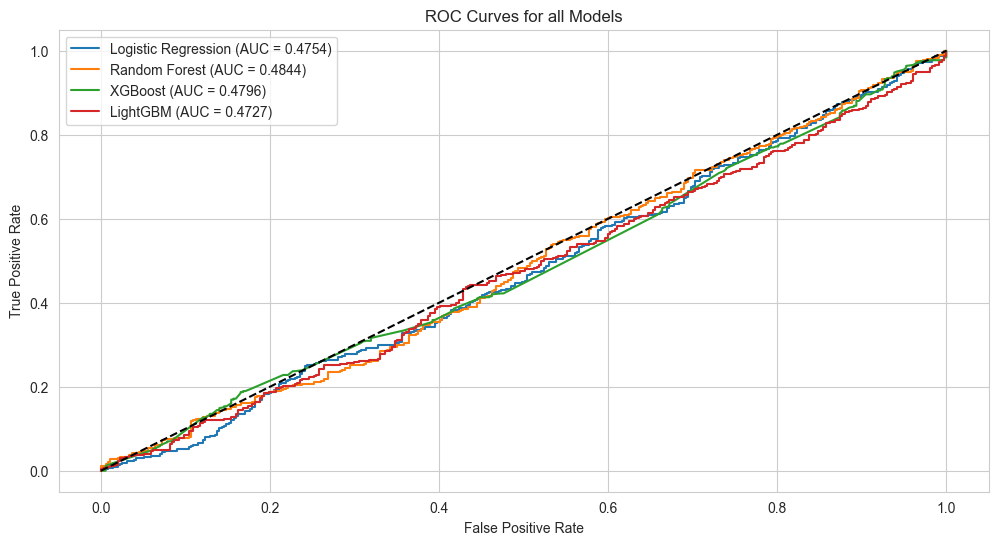

In [40]:
# AA - Adding ROC curves for all three models

def roc_curve_plt(model, X_test, y_test, label):
    #we first need the probability of UP for tomorrow

    probs = model.predict_proba(X_test)[:, 1]

    #next we need the false positives and true positives
    fpr, tpr, _ = roc_curve(y_test, probs)

    #we compute AUC score based on the curve
    roc_auc = auc(fpr, tpr)

    #now we can do the actual plot
    plt.plot(fpr, tpr, label = f"{label} (AUC = {roc_auc:.4f})")

plt.figure(figsize=(12,6))


# AA - we can plot ROC curve for each model
roc_curve_plt(best_lr, X_test, y_test, "Logistic Regression")
roc_curve_plt(best_rf, X_test, y_test, "Random Forest")
roc_curve_plt(best_xgb, X_test, y_test, "XGBoost")
roc_curve_plt(best_lgb, X_test, y_test, "LightGBM")

# AA - we can add a diagonal line which indicates random guessing
plt.plot([0,1], [0,1], 'k--')

plt.title("ROC Curves for all Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

## Baseline Accuracy

**Baseline Accuracy**

The baseline (always predict UP) is 55.19%.
Our best model (XGBoost at 55%) does not beat the baseline.

This is important and aligns with market efficiency theory.

In [43]:
#RS
baseline = y_test.value_counts(normalize=True).max()
print("Baseline accuracy:", baseline)

Baseline accuracy: 0.55375


## Feature Importance

**Feature Importance Insights**

Most models rely heavily on:

- Lagged returns
- Volatility (rolling std)
- MACD / MACD signal
- SMA differences
    
These features reflect short-term momentum and market noise.

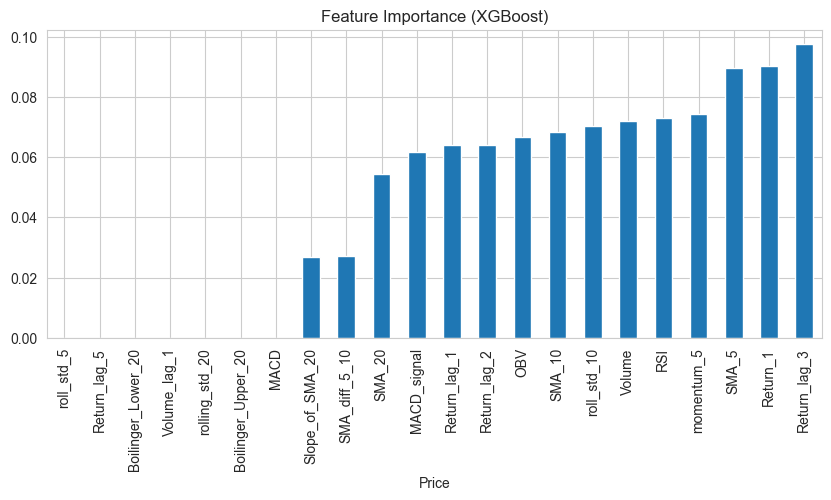

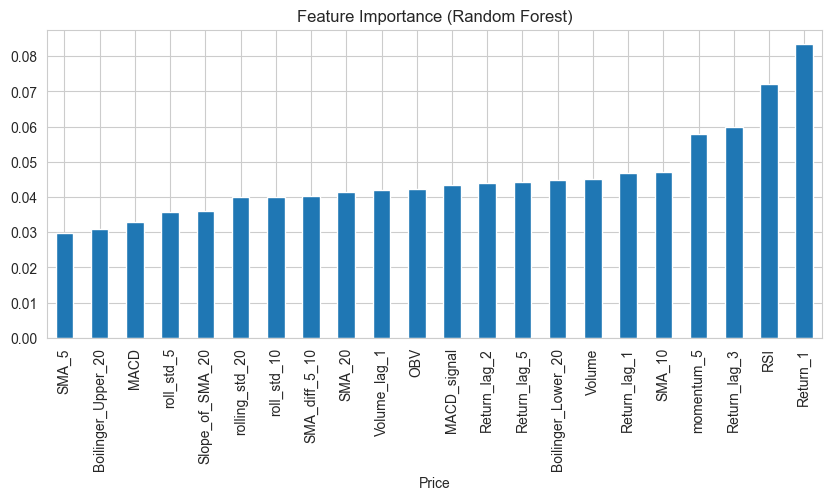

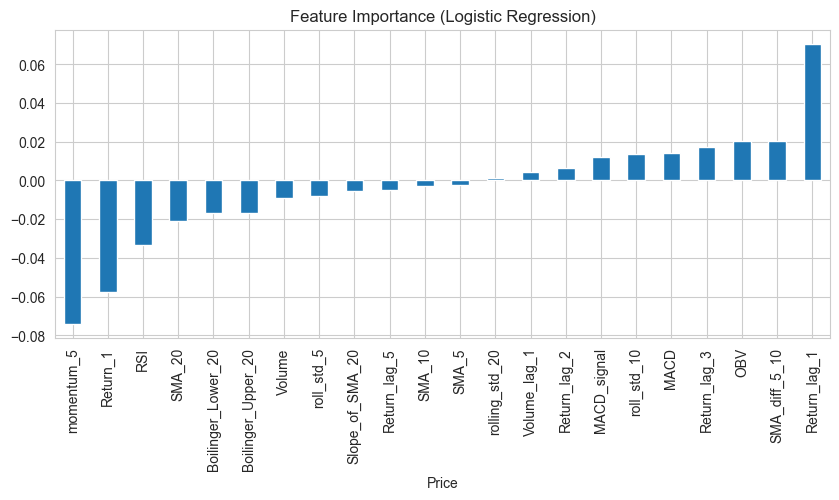

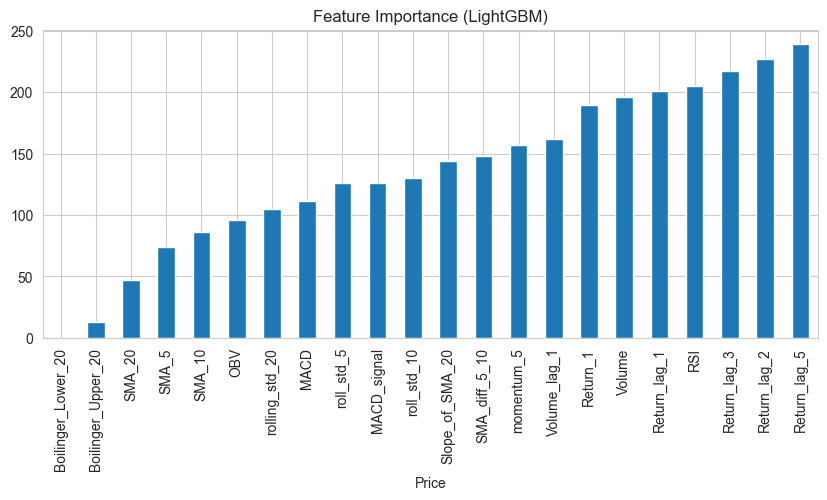

In [46]:
#RS
# XGBoost
try:
    importances = pd.Series(best_xgb.named_steps['clf'].feature_importances_,
                            index=X.columns)
    importances.sort_values().plot(kind='bar', figsize=(10,4))
    plt.title("Feature Importance (XGBoost)")
    plt.show()
except:
    pass

# Random Forest
try:
    rf_importances = pd.Series(best_rf.named_steps['clf'].feature_importances_,
                               index=X.columns)
    rf_importances.sort_values().plot(kind='bar', figsize=(10,4))
    plt.title("Feature Importance (Random Forest)")
    plt.show()
except:
    pass

# Logistic Regression
try:
    coefs = pd.Series(best_lr.named_steps['clf'].coef_[0], index=X.columns)
    coefs.sort_values().plot(kind='bar', figsize=(10,4))
    plt.title("Feature Importance (Logistic Regression)")
    plt.show()
except:
    pass

# LightGBM - AA

try:
    lgb_clf = best_lgb.named_steps['clf']
    lgb_importances = pd.Series(lgb_clf.feature_importances_,index=X.columns)
    lgb_importances.sort_values().plot(kind='bar', figsize=(10,4))
    plt.title("Feature Importance (LightGBM)")
    plt.show() 
except Exception as e:
    print("Could not plot Feature importance for LightGBM:", e)

## Rolling 50-Day Accuracy

**Rolling Accuracy Interpretation**

Rolling 50-day accuracy fluctuates near the baseline. Models perform well during trending markets but poorly during volatile or sideways periods.

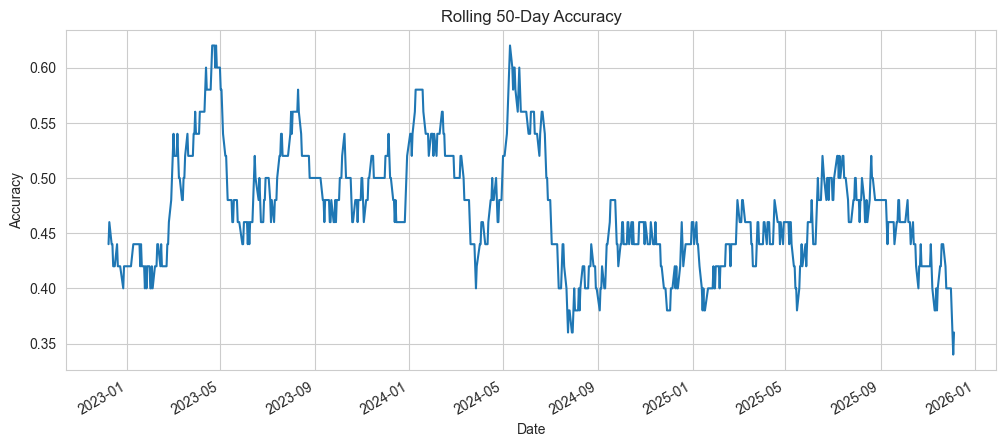

In [49]:
#RS
final_model = best_xgb

# Align features to model training
model_features = final_model.feature_names_in_
X_test_aligned = X_test[model_features]

preds = final_model.predict(X_test_aligned)

results = pd.DataFrame({
    "Date": data['Date'].iloc[split_index:],
    "Actual": y_test.values,
    "Pred": preds})

results['Correct'] = results['Actual'] == results['Pred']

results.set_index("Date")['Correct'].rolling(50).mean().plot(figsize=(12,5))
plt.title("Rolling 50-Day Accuracy")
plt.ylabel("Accuracy")
plt.show()

### Pick and save best model

In [51]:
#RS

#AA - adding to this by model selection using ROC-AUC
# candidates = {
#     "logreg": (best_lr, acc_lr),
#     "rf": (best_rf, acc_rf),
#     "xgb": (best_xgb, acc_xgb)}

#AA
candidates = {
    "Logistic Regression": metrics_lr,
    "Random Forest": metrics_rf,
    "XGBoost": metrics_xgb,
    "LightGBM": metrics_lgb}

# best_name = max(candidates, key=lambda k: candidates[k][1])
# best_model = candidates[best_name][0]


best_name = max(candidates, key=lambda name: candidates[name]["roc_auc"]) #AA
best_model_metrics = candidates[best_name] #AA

print(f"Best model(based on ROC-AUC): {best_name}") #RS/AA updated to make sure its know to be based off ROC-AUC
print(f"Metrics: {best_model_metrics}") #AA

#AA - Adding to save the actual model itself

if best_name == "Logistic Regression":
    final_model = best_lr
elif best_name == "Random Forest":
    final_model = best_rf
elif best_name == "LightGBM":
    final_model = best_lgb
else:
    final_model = best_xgb
    
joblib.dump(final_model, "sp500_model_capstone.joblib")

Best model(based on ROC-AUC): Random Forest
Metrics: {'accuracy': 0.4475, 'roc_auc': 0.4844041454053405}


['sp500_model_capstone.joblib']

To choose the best model, we compared ROC-AUC scores of all four of our models:

Logistic Regression
Random Forest
XGBoost
LightGBM
We choose ROC-AUC because its better for data with class imbalance. Accuracy can be especially be misleading when there is class imbalance.

The model with the highest ROC-AUC score is then selected as our final model. This model is then used for the daily predictions and threshold tuning.

In [53]:
# AA - Creating a quick data frame of all model metrics

df_metrics = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "LightGBM"],
    "Accuracy": [metrics_lr["accuracy"]
                 ,metrics_rf["accuracy"]
                 ,metrics_xgb["accuracy"]
                 ,metrics_lgb["accuracy"]],
    "ROC_AUC": [metrics_lr["roc_auc"]
                ,metrics_rf["roc_auc"]
                ,metrics_xgb["roc_auc"]
                ,metrics_lgb["roc_auc"]]
})

print("Overall Model performace summary for the test set:")
display(df_metrics)

Overall Model performace summary for the test set:


,Model,Accuracy,ROC_AUC
0,Logistic Regression,0.43625,0.475368
1,Random Forest,0.44750,0.484404
2,XGBoost,0.46750,0.479627
3,LightGBM,0.47375,0.472681


In [54]:
# AA - incorporate the best threshold

threshold_final = 0.40

def final_pred(model, X, threshold = threshold_final):
    probs = model.predict_proba(X)[:, 1]
    return (probs > threshold).astype(int)

## DAILY PREDICTION PIPELINE

**Daily Prediction Interpretation**

The random forest model, chosen by ROC-AUC predicts the next day’s direction and probability for UP.

- This model used the latest technical features and give the probability of the next day being UP.
- Instead of using the default threshold of 0.50, we chose a 0.40 threshold because it gave better accuracy and balance for our tests
- This threshold basically says if the probability of UP is above 40% we predict UP otherwise the prediction is DOWN.

In [57]:
#RS
model = final_model #AA - UPDATED

# Align feature order
model_features = model.feature_names_in_
X_latest = X.iloc[[-1]][model_features]

pred = final_pred(model, X_latest)[0]
prob = model.predict_proba(X_latest)[0][1]

# Convert to percent and round to 2 decimals
prob_percent = round(prob * 100, 2)

print("Prediction for next trading day after:", data['Date'].iloc[-1])
print("Predicted direction:", "UP" if pred == 1 else "DOWN")
print(f"Probability of UP: {prob_percent:.2f}%")

Prediction for next trading day after: 2025-12-05 00:00:00
Predicted direction: DOWN
Probability of UP: 37.01%


### Final Summary

This project explored predicting daily S&P 500 direction using traditional technical indicators.
    
**Key Findings**
    
No model beat the baseline accuracy (predict UP every day).

**Comparison of baseline to models**

- We have a simple baseline rule of always predicting UP which gets an accuracy of around 55% on the test set.
- All tuned models do not beat the baseline and had around 43-47% accuracy

**ROC-AUC**

- The ROC-AUC for all models reched around 0.47-0.48 on the test set.
- Rodom Forest was our best model at about 0.48, however this isn't better than random guessing would be at 0.50.

**Improvement Attempts**

- Addition of more features such as Volatility, Bollinger Bands, Momentum, OBV.
- Handling of class imbalance and a tuned threshold

While these improvements give us a more robust evaluation but didn't create a strong predictive model.

**What this means/Bigger Picture**

- Down days are still very hard to predict over up days.
- the models stuggled to reliably separate a down versus up days, supporting the idea that short-term price direction is hard to forecast.
  
**Interpretation**

The results show that daily market movement is hard to predict, even with additional features and machine learning models. None of them were able to beat baseline and this strongly suggests that daily changes are mostly noise, making the next day predictions difficult.

**Possible Next Steps**

- Include macroeconomic indicators (VIX, yield curve, unemployment).
- Explore longer-horizon predictions (weekly/monthly).
- Add regime detection (bull/bear markets).
- Try hybrid models or ensemble approaches.
  
The notebook provides a realistic, interpretable analysis consistent with both data science and financial theory.

**Review Notes:** My only feedback is I feel like some efforts were duplicated and we could've made it a bit cleaner. For example the split logic was done like this split_index = int(0.8 * len(X))....

and then later done like this TimeSeriesSplit(n_splits=5) - AA

**Review Notes:** The notebook worked well, but some parts felt a bit repetitive and could be cleaned up. Next time, we could focus on experimenting with different model setups, tuning thresholds, or trying ensemble approaches to see if we can get more consistent predictions. - RS

**Review Notes:** I believe this notebook went into great detail about our model evaluation, but we could try exploring more options to prevent repeating ourselves. - CG

This notebook was run end-to-end on my local machine without errors - AA

This notebook was run end-to-end on my local machine without errors - RS

This notebook was run end-to-end on my local machine without errors - CG